In [1]:
import glob
import os, sys, subprocess
import ROOT as rt
import re
import glob
import numpy as np
%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.18/02


In [2]:
np.random.randint(10)

4

In [3]:
indir1 = '/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/'
indir2 = '/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/orderByPt/withcut/'
filelist = sorted(glob.glob(indir1+'/*.root'))
#all_signal_file = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/GMSB_triggerEffCuts.root'


lumi_2016 = 35922.0
lumi_2017 = 41530.0
lumi = lumi_2016

lambda_points = [400]
ctau_points = [10, 200, 1000]
marker_size = 1

bkg_list = {'DiPhoton': [],
               'GJet': [],
               'QCD': [],
                'Z': [],
                'W': [],
                'T': [],
                'tt': []
              }

bkg_color = {'DiPhoton': rt.kOrange-2,
                'GJet': rt.kAzure+1,
                'QCD': rt.kMagenta-7,
                'GMSB': rt.kOrange-3,
                'GMSBAll': rt.kBlack,
                'Data': rt.kBlack,
                 'Z': rt.kAzure+10,
                'W': rt.kAzure+10,
                'T': rt.kAzure+10,
                'tt': rt.kAzure+10}

sample_color = [rt.kBlack,
               rt.kRed,
               rt.kPink+9,
               rt.kMagenta+2,
               rt.kViolet+6,
               rt.kBlue,
               rt.kAzure,
               rt.kAzure+7,
               rt.kCyan+2,
               rt.kTeal-6,
               rt.kGreen+3,
               rt.kSpring+4,
               rt.kYellow-2]

sample_marker = [39, 41, 43, 45, 47, 48, 49, 21, 22, 23, 29, 33, 34]

def getXS(sample):
    with open("/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/data/all_bkg_back.list", "r") as xsfile:
        allxs = xsfile.readlines()
        for xs in allxs:
            if xs.split(' ')[0] in sample:
                return xs.split(' ')[-1].replace('\n','')
    print("[WARNING] {} cross section not found".format(sample))
    return 0

def extract_num(string):
    sample_num = list(map(int, re.findall(r'\d+', string.split('/')[-1])))
    if len(sample_num) > 1:
        sample_lambda, sample_ctau = sample_num[0], sample_num[1]
        if sample_ctau == 0:
            if "0_001cm" in string:
                sample_ctau = 0.001
            elif "0_01cm" in string:
                sample_ctau = 0.01
            elif "0_1cm" in string:
                sample_ctau = 0.1

        return sample_lambda, sample_ctau
    else:
        print("Can't extract number from {}".format(string))
        return 0, 0

def getSignalXS(sample):
    """Get cross section x BR for signal MC"""
    sample_lambda, sample_ctau = extract_num(sample)

    dat_file = "/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/data/XsecBR.dat"
    with open(dat_file, "r") as xsfile:
        allxs = xsfile.readlines()
        for xs in allxs[1:]:
            this_lambda, this_ctau = extract_num(xs)
            if sample_lambda == this_lambda and sample_ctau == this_ctau:
                return float(xs.split(' ')[4])
    print("[WARNING] {} cross section not found in {}".format(sample, dat_file))
    return 0


In [4]:
features = ['t1MET', 'HT', 'HT_incPho', 'n_Jets', 'jet1Pt', 'jet2Pt']
xranges = {'t1MET': (0, 800),
          'HT': (0, 8000),
           'HT_incPho': (0, 8000),
           'n_Jets': (0, 10),
           'jet1Pt': (0, 500),
            'jet2Pt': (0, 500)}
useLogY = {'t1MET': False,
          'HT': True,
           'HT_incPho': True,
           'n_Jets': False,
          'jet1Pt': False,
           'jet2Pt': False}

for pho_to_plot in [1]:
    features.extend(['pho{}Pt'.format(pho_to_plot), 
                'pho{}ecalPFClusterIso'.format(pho_to_plot), 
#                 'pho{}hcalPFClusterIso'.format(pho_to_plot),
#                 'pho{}trkSumPtHollowConeDR03'.format(pho_to_plot), 
#                 'pho{}R9'.format(pho_to_plot), 
#                 'pho{}SigmaIetaIeta'.format(pho_to_plot), 
#                 'pho{}Smajor'.format(pho_to_plot), 
#                 'pho{}Sminor'.format(pho_to_plot),
#                 'pho{}angle_xtal'.format(pho_to_plot),    
#                 'pho{}ClusterTime_SmearToData'.format(pho_to_plot),
#                 'pho{}_genVtxZ'.format(pho_to_plot),
                'R{}'.format(pho_to_plot)])

    xranges.update({
               'pho{}Pt'.format(pho_to_plot): (40,500),
               'pho{}ecalPFClusterIso'.format(pho_to_plot): (0,8),
               'pho{}hcalPFClusterIso'.format(pho_to_plot): (0, 8),
               'pho{}trkSumPtHollowConeDR03'.format(pho_to_plot): (0,8),
               'pho{}R9'.format(pho_to_plot): (0.84,1.),
               'pho{}SigmaIetaIeta'.format(pho_to_plot): (0, 0.025),
               'pho{}Smajor'.format(pho_to_plot): (0, 2.),
               'pho{}Sminor'.format(pho_to_plot): (0., 1.),
               'pho{}ClusterTime_SmearToData'.format(pho_to_plot): (-2, 5),
               'pho{}angle_xtal'.format(pho_to_plot): (0, 1.),
               'pho{}_genVtxZ'.format(pho_to_plot): (-1500, 1500),
               'R{}'.format(pho_to_plot): (0, 1000)
    })

    useLogY.update({
               'pho{}Pt'.format(pho_to_plot): False,
               'pho{}ecalPFClusterIso'.format(pho_to_plot): True,
               'pho{}hcalPFClusterIso'.format(pho_to_plot): True,
               'pho{}trkSumPtHollowConeDR03'.format(pho_to_plot): True,
               'pho{}R9'.format(pho_to_plot): False,
               'pho{}SigmaIetaIeta'.format(pho_to_plot): True,
               'pho{}Smajor'.format(pho_to_plot): True,
               'pho{}Sminor'.format(pho_to_plot): True,
               'pho{}ClusterTime_SmearToData'.format(pho_to_plot): True,
               'pho{}angle_xtal'.format(pho_to_plot): True,
               'pho{}_genVtxZ'.format(pho_to_plot): True,
               'R{}'.format(pho_to_plot): True
    })


In [5]:
hist_list = {}
allsn_hist = {}


event_cut = ' '
pho_cut = 'pho1Pt > 70 && abs(pho1Eta)<1.4442 \
            && abs(pho1HoverE) < 0.08 \
            && pho1R9 > 0.85 && abs(pho1SigmaIetaIeta) < 0.024 \
            && pho1passEleVeto'
met_cut = " && Flag_HBHENoiseFilter == 1 && Flag_HBHEIsoNoiseFilter ==1 && \
       Flag_goodVertices == 1 && Flag_eeBadScFilter == 1 && \
       Flag_EcalDeadCellTriggerPrimitiveFilter == 1 && \
       Flag_CSCTightHaloFilter == 1  && \
       Flag_badMuonFilter == 1 && Flag_badGlobalMuonFilter == 0 && \
       Flag_duplicateMuonFilter == 0 "



for fea in features:
    hist_list[fea] = []
    color_index = 0
    
    bins=100
    if 'n_Jets' in fea: bins=xranges['n_Jets'][1]
    
    for sample in filelist:
        if 'GMSB' in sample:
            ### Get lambda and ctau 
            this_lambda, this_ctau = extract_num(sample)
            if int(this_lambda) in lambda_points and int(this_ctau) in ctau_points:
                color_index += 1
                xs = getSignalXS(sample)
                
                if xs and xs != 0:
                    
                    tmp_file = rt.TFile.Open(sample, "READ")
                    tmp_tree = tmp_file.Get("DelayedPhoton")
                    tmp_sw = tmp_file.Get("SumWeights")
                    sumWeights = tmp_sw.Integral()
                    hist_list[fea].append(rt.TH1F("hist[{}]_{}_{}".format(fea, this_lambda, this_ctau), 
                                                  "{}; {}".format(sample, fea), bins, xranges[fea][0], xranges[fea][1]))


                    xsecOverSumweights = float(xs)/sumWeights
                    weight_selection = "({event_cut} {pho_cut} {met_cut}) * (weight * \
                                        pileupWeight * {lumi} * {xsecOverSumweights})".format(event_cut=event_cut,
                                                                                            pho_cut = pho_cut,
                                                                                            met_cut=met_cut,
                                                                                            lumi=lumi,
                                                                                            xsecOverSumweights=xsecOverSumweights)
#                     weight_selection = "(HLTDecision[81] == 1) * (weight * \
#                                         pileupWeight * {lumi} * {xsecOverSumweights})".format(event_cut=event_cut,
#                                                                                             pho_cut = pho_cut,
#                                                                                             met_cut=met_cut,
#                                                                                             lumi=lumi,
#                                                                                             xsecOverSumweights=xsecOverSumweights)

                    tmp_tree.Draw("{}>>hist[{}]_{}_{}".format(fea, fea, this_lambda, this_ctau), weight_selection)
                    hist_list[fea][-1].SetDirectory(0)
                    print("{}\n\tWeighted sum events = {:.2f}\n\txs = {}\n\txs/sumWeight = {}".format(sample, 
                                                                               hist_list[fea][-1].Integral(),
                                                                               xs, xsecOverSumweights))
                    hist_list[fea][-1].SetFillColor(sample_color[color_index])
                    hist_list[fea][-1].SetLineColor(sample_color[color_index])
                    hist_list[fea][-1].SetMarkerSize(marker_size)
                    hist_list[fea][-1].SetMarkerStyle(sample_marker[color_index])
                    hist_list[fea][-1].SetMarkerColor(sample_color[color_index])

                    del tmp_file, tmp_tree, tmp_sw

#     # Get all signal histogram
#     allsn_file = rt.TFile.Open(all_signal_file, "READ")
#     allsn_tree = allsn_file.Get("DelayedPhoton")
#     allsn_sw = allsn_file.Get("SumWeights")
#     sumWeights = allsn_sw.Integral()
#     xsecOverSumweights = allsn_tree.GetEntries()/sumWeights

#     allsn_hist[fea] = rt.TH1F("all_hist_signal[{}]".format(fea), 
#                               "{}; {}".format(sample, fea), 
#                               100, xranges[fea][0], xranges[fea][1])
#     weight_selection = "(HLTDecision[81] == 1) * (weight * \
#                         pileupWeight * {lumi} * {xsecOverSumweights})".format(event_cut=event_cut,
#                                                                             pho_cut = pho_cut,
#                                                                             met_cut=met_cut,
#                                                                             lumi=lumi,
#                                                                             xsecOverSumweights=xsecOverSumweights)
#     allsn_tree.Draw("{}>>all_hist_signal[{}]".format(fea, fea), weight_selection)
#     allsn_hist[fea].SetDirectory(0)
#     print("{}\n\tWeighted sum events = {:.2f}\n\txs/sumWeight = {}".format(all_signal_file, 
#                                                                allsn_hist[fea].Integral(),
#                                                                xsecOverSumweights))
#     allsn_hist[fea].SetFillColor(sample_color[0])
#     allsn_hist[fea].SetLineColor(sample_color[0])
#     allsn_hist[fea].SetLineWidth(2)
#     allsn_hist[fea].SetMarkerStyle(20)#(sample_marker[-1])
#     allsn_hist[fea].SetMarkerSize(marker_size)
#     #allsn_hist[fea].Scale(1./10000.)

/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/GMSB_L-400TeV_Ctau-1000cm_13TeV-pythia8.root
	Weighted sum events = 4.75
	xs = 0.0007779
	xs/sumWeight = 7.825866546886844e-09
/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/GMSB_L-400TeV_Ctau-10cm_13TeV-pythia8.root
	Weighted sum events = 20.26
	xs = 0.0007785
	xs/sumWeight = 7.839476399004867e-09
/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/GMSB_L-400TeV_Ctau-200cm_13TeV-pythia8.root
	Weighted sum events = 11.22
	xs = 0.0007784
	xs/sumWeight = 7.0506408155247245e-09
/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/GMSB_L-400TeV_Ctau-1000cm_13TeV-pythia8.root
	Weighted sum events = 5.10
	xs = 0.0007779
	xs/sumWeight = 7.825866546886844e-09
/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/GMSB_L-400TeV_Ctau-10cm_13TeV-py

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


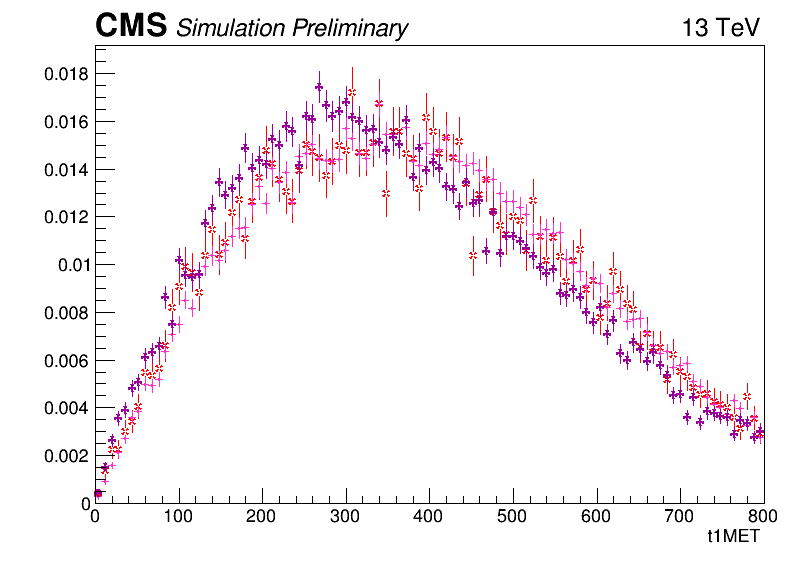

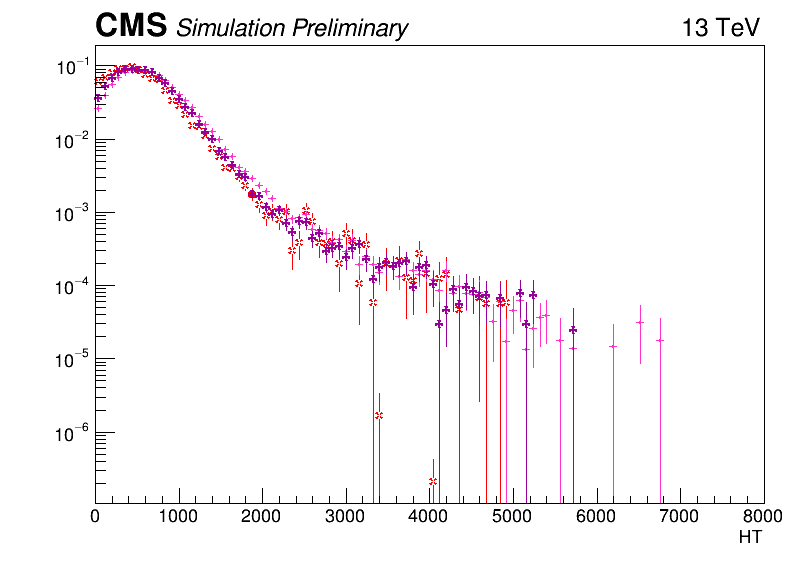

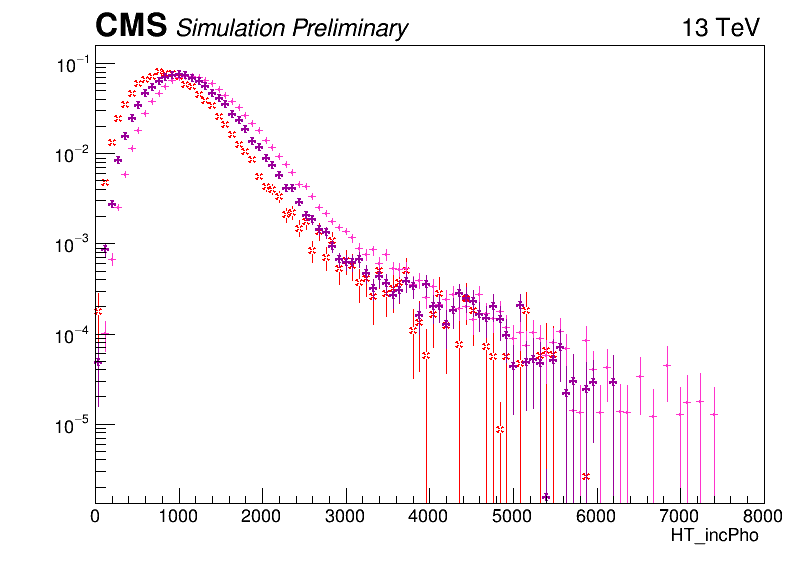

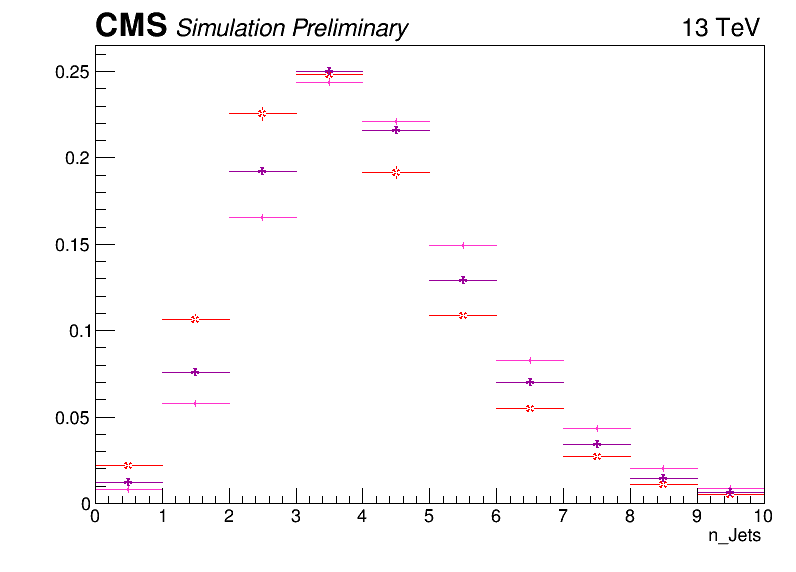

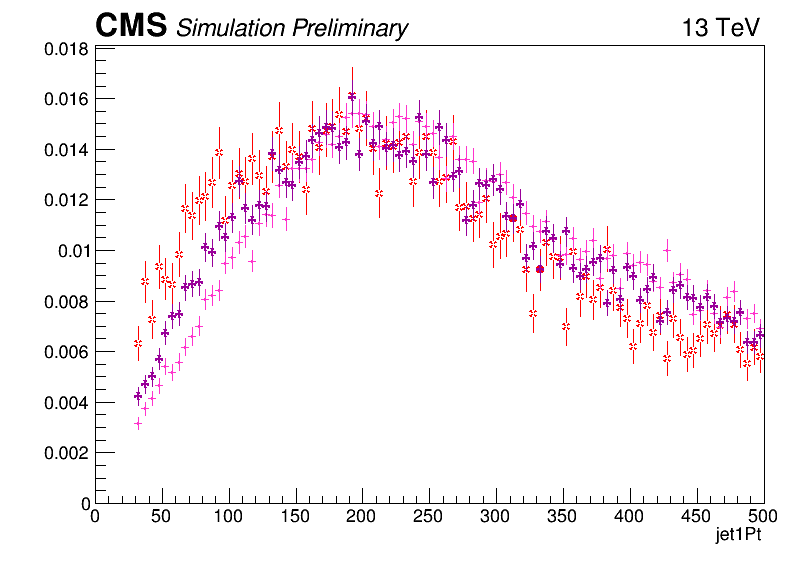

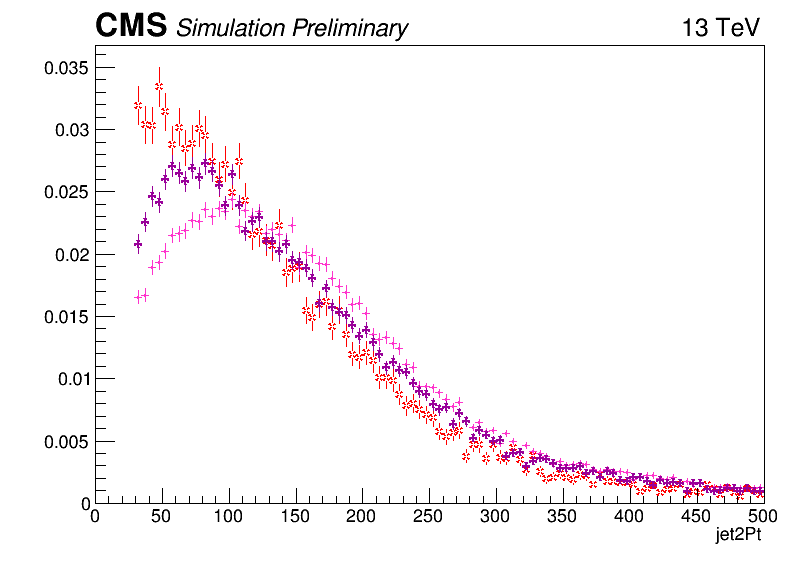

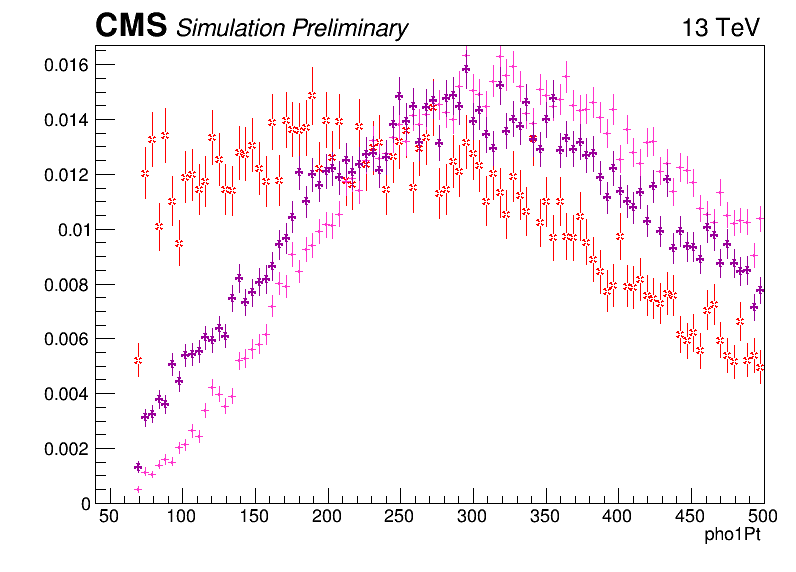

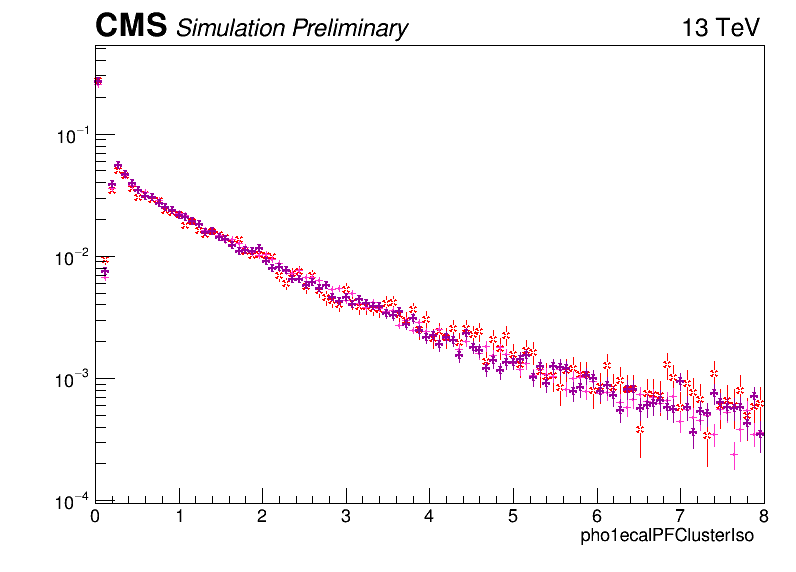

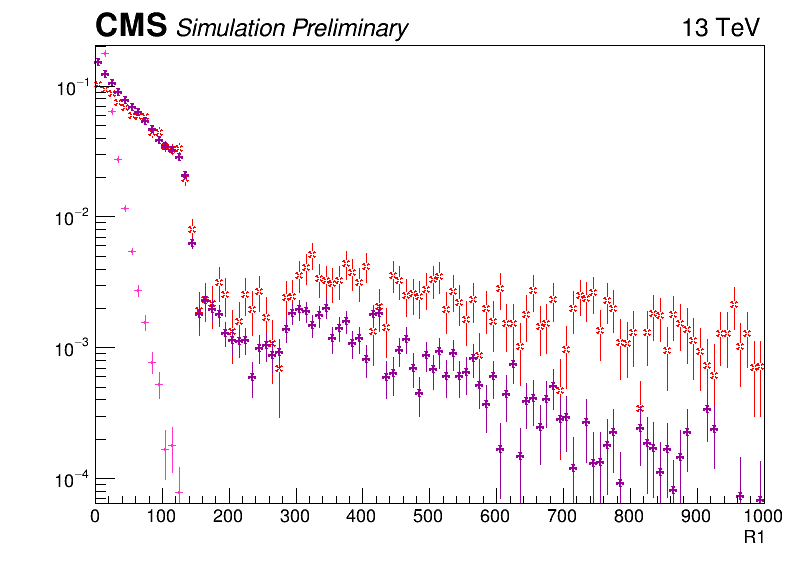

In [6]:
#### import plotLib.CMS_lumi as CMS_lumi
import plotLib.tdrstyle as tdrstyle
import plotLib.CMS_lumi as CMS_lumi

tdrstyle.setTDRStyle()

rt.gStyle.SetOptStat(0)
#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "Simulation Preliminary"
CMS_lumi.lumi_sqrtS = "13 TeV" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)

iPos = 0
if( iPos==0 ): CMS_lumi.relPosX = 0.12

H_ref = 600;
W_ref = 800;
W = W_ref
H  = H_ref
iPeriod = 0

# references for T, B, L, R
T = 0.08*H_ref
B = 0.12*H_ref
L = 0.12*W_ref
R = 0.04*W_ref


c1 = {}
leg = {}
h_dummy = {}
for i, fea in enumerate(features):
    c1[fea] = rt.TCanvas("c1[{}]".format(fea),"",50, 50, W, H)
    c1[fea].cd()
    c1[fea].SetFillColor(0)
    c1[fea].SetBorderMode(0)
    c1[fea].SetFrameFillStyle(0)
    c1[fea].SetFrameBorderMode(0)
    c1[fea].SetLeftMargin( L/W )
    c1[fea].SetRightMargin( R/W )
    c1[fea].SetTopMargin( T/H )
    c1[fea].SetBottomMargin( B/H )
    c1[fea].SetTickx(0)
    c1[fea].SetTicky(0)
    rt.gStyle.SetOptStat(0)
#     h_dummy[fea] = signal_hist[fea].Clone("dummy{}".format(fea));
#     h_dummy[fea].SetTitle("")
#     h_dummy[fea].SetLineColor(0);
#     h_dummy[fea].SetFillColor(0);
#     h_dummy[fea].SetMarkerColor(0)
#     h_dummy[fea].GetYaxis().SetTitleOffset(1.1)
#     h_dummy[fea].SetDirectory(0)
#     # Get max Y
#     hsum = hstack[fea].GetStack().Last()
#     maxY = max([hsum.GetMaximum(), signal_hist[fea].GetMaximum(), allsn_hist[fea].GetMaximum()])
#     h_dummy[fea].SetAxisRange(1e-1,maxY*1.3,"Y")
#     h_dummy[fea].Draw()

#     hstack[fea].Draw("hist same")
#     hstack[fea].SetName("")
#     hstack[fea].GetXaxis().SetTitle(fea)
#     hstack[fea].GetXaxis().SetTitleSize(0.05)
    
    for hist in hist_list[fea]:
        hist.Scale(1./hist.Integral())
        hist.Draw("L same")
        
#     allsn_hist[fea].Scale(1./allsn_hist[fea].Integral())
#     allsn_hist[fea].Draw("L same")
        
    if useLogY[fea]:
        rt.gPad.SetLogy()
        
    rt.gStyle.SetOptStat(0)
#     if i==0:
#         leg[fea] = rt.TLegend(0.6,0.3,0.89,0.89)
#         leg[fea].SetBorderSize(0)
#         for hist in hist_list[fea]:
#             hist_name = hist.GetName()
#             hist_lambda, hist_ctau = hist_name.split('_')[-2], hist_name.split('_')[-1]
#             leg[fea].AddEntry(hist, "#Lambda = {}TeV, c#tau = {}cm".format(hist_lambda, hist_ctau), "l")
#         leg[fea].AddEntry(allsn_hist[fea], "All GMSB (#Lambda #geq 200TeV)", 'l')
#         leg[fea].Draw()
    
    c1[fea].Draw()
        
    #draw the lumi text on the c1[fea]
    CMS_lumi.CMS_lumi(c1[fea], iPeriod, iPos)

    c1[fea].cd()
    c1[fea].Update()
    c1[fea].RedrawAxis()
    frame = c1[fea].GetFrame()
    frame.Draw()



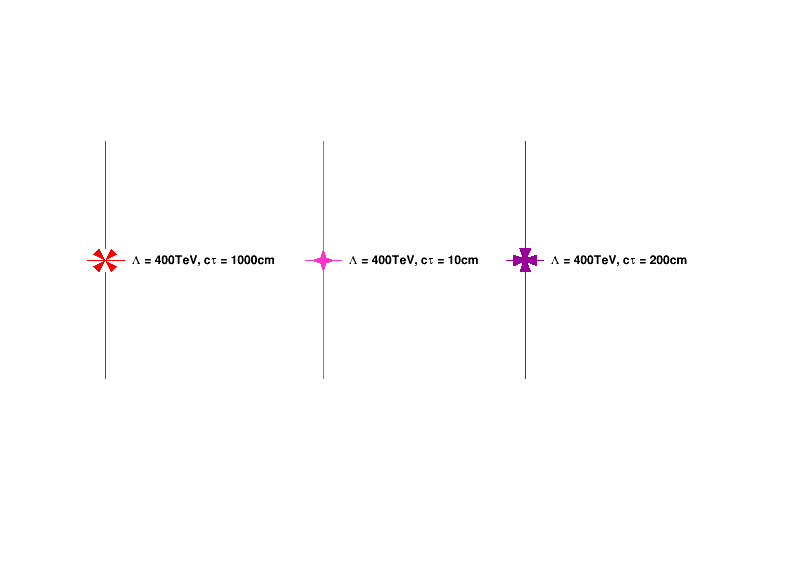

In [7]:
# Canvas for legend
rt.gStyle.SetOptStat(0)

fea = features[-1]
cleg = rt.TCanvas("cleg", "", 50, 50, W, H)
cleg.cd()
leg[fea] = rt.TLegend(0.1,0.2,0.89,0.89)
leg[fea].SetNColumns(3)
leg[fea].SetBorderSize(0)
for hist in hist_list[fea]:
    hist_name = hist.GetName()
    hist.SetMarkerSize(3)
    hist_lambda, hist_ctau = hist_name.split('_')[-2], hist_name.split('_')[-1]
    leg[fea].AddEntry(hist, "#Lambda = {}TeV, c#tau = {}cm".format(hist_lambda, hist_ctau), "lep")
#leg[fea].AddEntry(allsn_hist[fea], "All GMSB (#Lambda #geq 200TeV)", 'lep')
leg[fea].Draw()
cleg.Draw()

Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016C.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016D.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016E.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016F.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016G.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016H.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/SinglePhoton_Run2016C.root
Can't ext

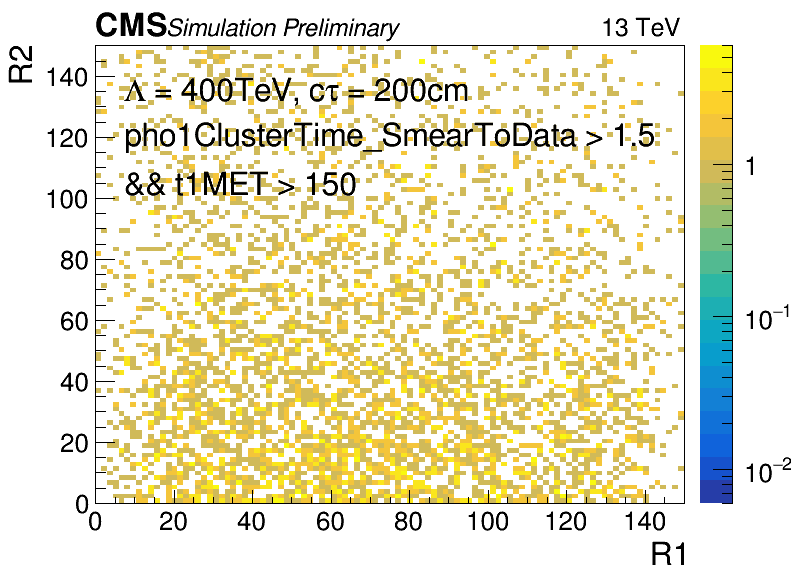

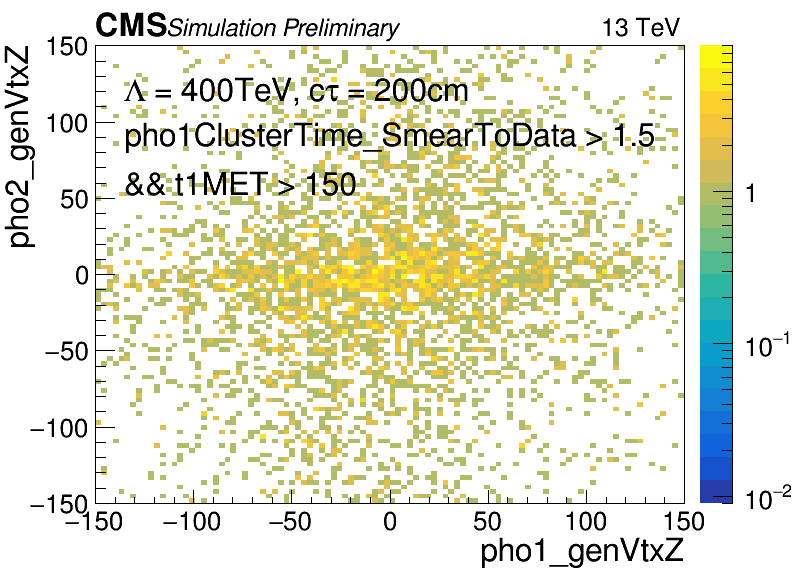

In [8]:
### 2D visualization of radius and decay Z of the 2 leading photons for low and high ctau
condition = "pho1ClusterTime_SmearToData > 1.5 && t1MET > 150"
target_lambda = 400
target_ctaus = [200]
radius = {}
decayZ = {}
for target_ctau in target_ctaus:
    for sample in filelist:
        ### Get lambda and ctau 
        this_lambda, this_ctau = extract_num(sample)
        if int(this_lambda) == target_lambda and int(this_ctau) == target_ctau:
            tmp_file = rt.TFile.Open(sample, "READ")
            tmp_tree = tmp_file.Get("DelayedPhoton")

            radius[target_ctau] = rt.TH2F("radius_{}_{}".format(target_lambda, target_ctau),
                             ";R1;R2", 100, 0, 150, 100, 0, 150)
            tmp_tree.Draw("R2:R1 >> radius_{}_{}".format(target_lambda, target_ctau), condition)
            radius[target_ctau].SetDirectory(0)
            
            decayZ[target_ctau] = rt.TH2F("decayZ_{}_{}".format(target_lambda, target_ctau),
                            ";pho1_genVtxZ; pho2_genVtxZ", 100, -150, 150, 100, -150, 150)
            tmp_tree.Draw("pho2_genVtxZ:pho1_genVtxZ >> decayZ_{}_{}".format(target_lambda, target_ctau), condition)
            decayZ[target_ctau].SetDirectory(0)
            tmp_file.Close()
            
plot2D = [radius, decayZ]

# Position of the text

for target_ctau in target_ctaus:
    for plot in plot2D:
        fea = np.random.randint(100)
        c1[fea] = rt.TCanvas("c1[{}]".format(fea),"",50, 50, W, H)
        c1[fea].cd()
        c1[fea].SetFillColor(0)
        c1[fea].SetBorderMode(0)
        c1[fea].SetFrameFillStyle(0)
        c1[fea].SetFrameBorderMode(0)
        c1[fea].SetLeftMargin( L/W )
        c1[fea].SetRightMargin( R/W +0.1)
        c1[fea].SetTopMargin( T/H )
        c1[fea].SetBottomMargin( B/H )
        c1[fea].SetTickx(0)
        c1[fea].SetTicky(0)
        rt.gStyle.SetOptStat(0)
        plot[target_ctau].GetYaxis().SetTitleOffset(1.0)
        plot[target_ctau].Draw("COLZ")
        rt.gPad.SetLogz()
        rt.gStyle.SetOptStat(0)
        c1[fea].Draw()

        #draw the lumi text on the c1[fea]
        CMS_lumi.CMS_lumi(c1[fea], iPeriod, iPos)

        c1[fea].cd()
        c1[fea].Update()
        c1[fea].RedrawAxis()
        frame = c1[fea].GetFrame()
        frame.Draw()

        # Add text 
        latex = rt.TLatex()
        latex.SetTextFont(42)
        latex.SetTextAngle(0)
        latex.SetTextColor(rt.kBlack)
        latex.SetTextSize(0.06)
        latex.SetTextAlign(12)
        xpos = plot[target_ctau].GetXaxis().GetXmin()+0.05*(plot[target_ctau].GetXaxis().GetXmax()-plot[target_ctau].GetXaxis().GetXmin())
        ypos = plot[target_ctau].GetYaxis().GetXmin()+0.9*(plot[target_ctau].GetYaxis().GetXmax()-plot[target_ctau].GetYaxis().GetXmin())
        ypos2 = plot[target_ctau].GetYaxis().GetXmin()+0.8*(plot[target_ctau].GetYaxis().GetXmax()-plot[target_ctau].GetYaxis().GetXmin())
        ypos3 = plot[target_ctau].GetYaxis().GetXmin()+0.7*(plot[target_ctau].GetYaxis().GetXmax()-plot[target_ctau].GetYaxis().GetXmin())

        latex.DrawLatex(xpos, ypos,"#Lambda = {}TeV, c#tau = {}cm".format(target_lambda, target_ctau))
        latex.DrawLatex(xpos, ypos2, "pho1ClusterTime_SmearToData > 1.5")
        latex.DrawLatex(xpos, ypos3, "&& t1MET > 150")

        c1[fea].Update()
        
        # Move color palette
        palette = plot[target_ctau].GetListOfFunctions().FindObject("palette")
        palette.SetX1NDC(0.88);
        palette.SetX2NDC(0.92);
        rt.gPad.Modified();
        rt.gPad.Update()

Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016C.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016D.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016E.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016F.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016G.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016H.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/SinglePhoton_Run2016C.root
Can't ext

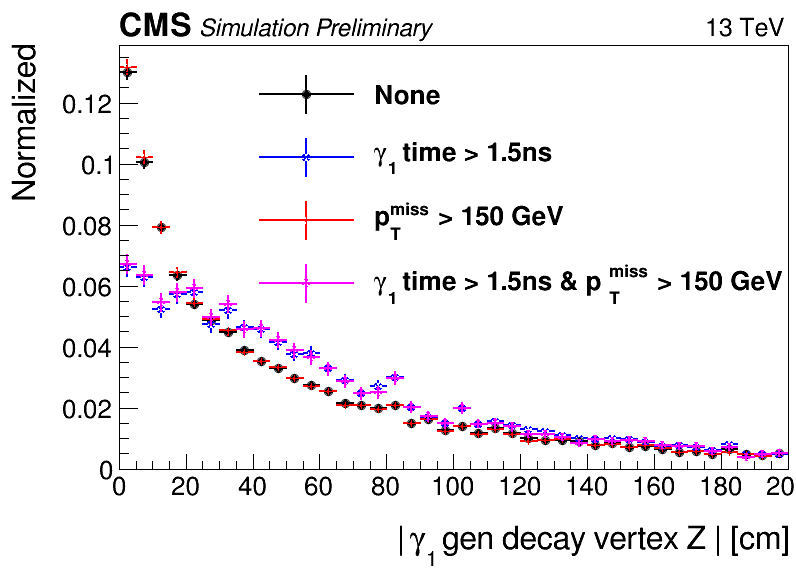

In [9]:
H_ref = 600;
W_ref = 800;
W = W_ref
H  = H_ref
iPeriod = 0

# references for T, B, L, R
T = 0.08*H_ref
B = 0.18*H_ref
L = 0.15*W_ref
R = 0.01*W_ref

### 1D visualization of R2 before and after the cuts
time_cut = "pho1ClusterTime_SmearToData > 1.5"
met_cut = "t1MET > 150"
colors = [rt.kBlack, rt.kBlue, rt.kRed, rt.kMagenta]
cuts = ["", time_cut, met_cut,time_cut+" && "+met_cut]
target_lambda = 400
target_ctaus = [200]
radius = {}
decayZ = {}
for target_ctau in target_ctaus:
    for sample in filelist:
        ### Get lambda and ctau 
        this_lambda, this_ctau = extract_num(sample)
        if int(this_lambda) == target_lambda and int(this_ctau) == target_ctau:
            tmp_file = rt.TFile.Open(sample, "READ")
            tmp_tree = tmp_file.Get("DelayedPhoton")
            for i, cut in enumerate(cuts):
                radius[cut] = rt.TH1F("R1_{}".format(cut),
                                 ";| #gamma_{1} gen decay vertex Z | [cm]; Normalized", 40, 0, 200)
                tmp_tree.Draw("abs(pho1_genVtxZ) >> R1_{}".format(cut), cut)
                radius[cut].SetDirectory(0)
                radius[cut].Scale(1./radius[cut].Integral())
                radius[cut].SetLineWidth(2)
                radius[cut].SetLineColor(colors[i])
                radius[cut].SetMarkerColor(colors[i])
                radius[cut].SetMarkerStyle(sample_marker[i])
                radius[cut].GetXaxis().SetTitleOffset(1.4)
                if i==0: radius[cut].SetMarkerStyle(20)

            tmp_file.Close()
            
fea = '1D'
c1[fea] = rt.TCanvas("c1[{}]".format(fea),"",50, 50, W, H)
c1[fea].cd()
c1[fea].SetFillColor(0)
c1[fea].SetBorderMode(0)
c1[fea].SetFrameFillStyle(0)
c1[fea].SetFrameBorderMode(0)
c1[fea].SetLeftMargin( L/W )
c1[fea].SetRightMargin( R/W)
c1[fea].SetTopMargin( T/H )
c1[fea].SetBottomMargin( B/H )
c1[fea].SetTickx(0)
c1[fea].SetTicky(0)
rt.gStyle.SetOptStat(0)
for cut in cuts:
    radius[cut].Draw("l same")
#rt.gPad.SetLogz()
rt.gStyle.SetOptStat(0)
c1[fea].Draw()

leg[fea] = rt.TLegend(0.3, 0.45,0.98,0.89)
leg[fea].SetBorderSize(0)
for cut in cuts:
    cut_label = 'None'
    if '&&' in cut:
        cut_label = '#gamma_{1} time > 1.5ns & p_{T}^{miss} > 150 GeV'
    elif 'pho1ClusterTime'in cut:
        cut_label = '#gamma_{1} time > 1.5ns'
    elif 'MET' in cut:
        cut_label = 'p_{T}^{miss} > 150 GeV'
    radius[cut].SetMarkerSize(1)
    leg[fea].AddEntry(radius[cut], cut_label, "lep")
leg[fea].Draw()

#draw the lumi text on the c1[fea]
CMS_lumi.CMS_lumi(c1[fea], iPeriod, iPos)

c1[fea].cd()
c1[fea].Update()
c1[fea].RedrawAxis()
frame = c1[fea].GetFrame()
frame.Draw()




Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016C.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016D.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016E.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016F.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016G.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/DoubleEG_Run2016H.root
Can't extract number from /mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/DelayedPhotonAnalysis/2016/legacy/hadd/SinglePhoton_Run2016C.root
Can't ext

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[1D]


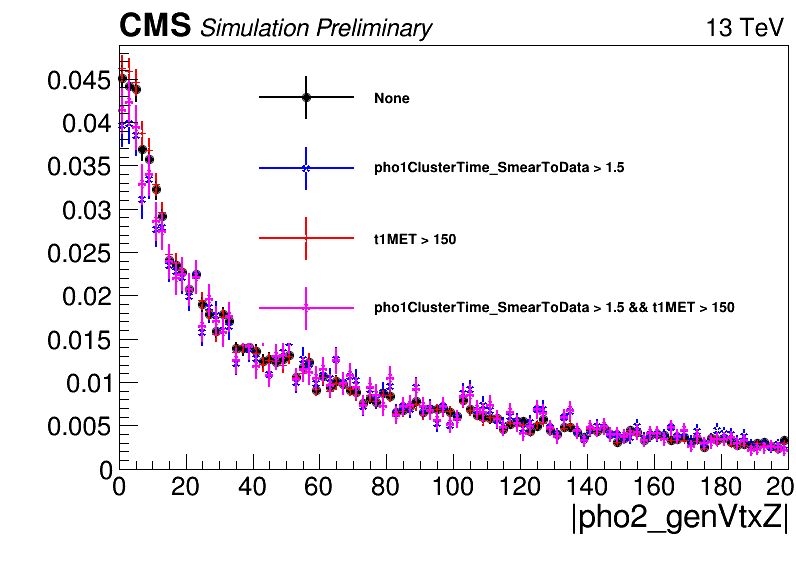

In [10]:
### 1D visualization of R2 before and after the cuts
time_cut = "pho1ClusterTime_SmearToData > 1.5"
met_cut = "t1MET > 150"
colors = [rt.kBlack, rt.kBlue, rt.kRed, rt.kMagenta]
cuts = ["", time_cut, met_cut, time_cut+" && "+met_cut]
target_lambda = 400
target_ctaus = [200]
radius = {}
decayZ = {}
for target_ctau in target_ctaus:
    for sample in filelist:
        ### Get lambda and ctau 
        this_lambda, this_ctau = extract_num(sample)
        if int(this_lambda) == target_lambda and int(this_ctau) == target_ctau:
            tmp_file = rt.TFile.Open(sample, "READ")
            tmp_tree = tmp_file.Get("DelayedPhoton")
            for i, cut in enumerate(cuts):
                radius[cut] = rt.TH1F("pho2_genVtxZ_{}".format(cut),
                                 ";|pho2_genVtxZ|", 100, 0, 200)
                tmp_tree.Draw("abs(pho2_genVtxZ) >> pho2_genVtxZ_{}".format(cut), cut)
                radius[cut].SetDirectory(0)
                radius[cut].Scale(1./radius[cut].Integral())
                radius[cut].SetLineWidth(2)
                radius[cut].SetLineColor(colors[i])
                radius[cut].SetMarkerColor(colors[i])
                radius[cut].SetMarkerStyle(sample_marker[i])
                if i==0: radius[cut].SetMarkerStyle(20)

            tmp_file.Close()
            
fea = '1D'
c1[fea] = rt.TCanvas("c1[{}]".format(fea),"",50, 50, W, H)
c1[fea].cd()
c1[fea].SetFillColor(0)
c1[fea].SetBorderMode(0)
c1[fea].SetFrameFillStyle(0)
c1[fea].SetFrameBorderMode(0)
c1[fea].SetLeftMargin( L/W )
c1[fea].SetRightMargin( R/W )
c1[fea].SetTopMargin( T/H )
c1[fea].SetBottomMargin( B/H )
c1[fea].SetTickx(0)
c1[fea].SetTicky(0)
rt.gStyle.SetOptStat(0)
for cut in cuts:
    radius[cut].Draw("l same")
#rt.gPad.SetLogz()
rt.gStyle.SetOptStat(0)
c1[fea].Draw()

leg[fea] = rt.TLegend(0.3,0.4,0.98,0.89)
leg[fea].SetBorderSize(0)
for cut in cuts:
    radius[cut].SetMarkerSize(1)
    leg[fea].AddEntry(radius[cut], "{}".format(cut) if cut!="" else "None", "lep")
leg[fea].Draw()

#draw the lumi text on the c1[fea]
CMS_lumi.CMS_lumi(c1[fea], iPeriod, iPos)

c1[fea].cd()
c1[fea].Update()
c1[fea].RedrawAxis()
frame = c1[fea].GetFrame()
frame.Draw()


